In [773]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd")

In [774]:
nyc_crime_raw = pd.read_csv('https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv')

In [775]:
nyc_crime_raw.head(5)

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [776]:
#Looks like there was descriptive text at the top of the file and the actual columns are seen in row 3 above.
#First rename the columns

nyc_crime_raw.columns = ['City', 'Population', 'ViolentCrime', 'Murder', 'Rape1', 'Rape2', 'Robbery', 
                     'AggravatedAssault', 'PropertyCrime', 'Burglary', 'LarcenyTheft', 'MotorVehicleTheft',
                    'Arson']

In [777]:
#Confirm the new columns are persisted

nyc_crime_raw.head(5)

,City,Population,ViolentCrime,Murder,Rape1,Rape2,Robbery,AggravatedAssault,PropertyCrime,Burglary,LarcenyTheft,MotorVehicleTheft,Arson
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0


In [778]:
#Now drop superfluous rows

nyc_crime = nyc_crime_raw.iloc[4:]

#Create a copy for later
nyc_crime_original = nyc_crime_raw.iloc[4:]

In [779]:
#Confirm row drop worked

nyc_crime.head(5)

,City,Population,ViolentCrime,Murder,Rape1,Rape2,Robbery,AggravatedAssault,PropertyCrime,Burglary,LarcenyTheft,MotorVehicleTheft,Arson
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
5,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
6,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
7,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
8,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN


In [780]:
#Describe the DataFrame

nyc_crime.describe()

,City,Population,ViolentCrime,Murder,Rape1,Rape2,Robbery,AggravatedAssault,PropertyCrime,Burglary,LarcenyTheft,MotorVehicleTheft,Arson
count,351,348,348,348,0.000,348,348,348,348,348,348,348,187
unique,351,347,82,14,0.000,26,51,69,239,124,232,51,13
top,Guilderland Town,"9,517",0,0,nan,0,0,0,0,0,0,0,0
freq,1,2,51,299,nan,204,139,66,6,21,7,93,133


In [781]:
nyc_crime.shape

(351, 13)

In [782]:
#Now that we know we have 351 observations across 13 columns, let's Find NaN's by column

missing_values_count = nyc_crime.isnull().sum()
print(missing_values_count)

City                   0
Population             3
ViolentCrime           3
Murder                 3
Rape1                351
Rape2                  3
Robbery                3
AggravatedAssault      3
PropertyCrime          3
Burglary               3
LarcenyTheft           3
MotorVehicleTheft      3
Arson                164
dtype: int64


In [783]:
#Drop NaN's in the columns we care most about

nyc_crime = nyc_crime.dropna(subset=['Population', 'Murder', 'Robbery', 'PropertyCrime'])

In [784]:
#Rename 'Rape2' to just 'Rape'

#Disable warning when making changes on a slice of original dataframe
pd.options.mode.chained_assignment = None

nyc_crime.rename(columns={'Rape2': 'Rape'}, inplace=True)

In [785]:
#Drop Rape1 since it contains no data

nyc_crime.drop(columns=['Rape1'], inplace=True)

### Now that data is clean, begin creating/converting features for Population Squared, Murder and Robbery

In [786]:
#To create population squared feature, first remove commas from amounts
nyc_crime['Population'] = nyc_crime['Population'].str.replace(',', '')

In [787]:
#Next, convert column from string to int

nyc_crime['Population'] = nyc_crime['Population'].astype(int)

In [788]:
#Now we can create our new feature!

nyc_crime['PopulationSquared'] = nyc_crime['Population']**2

In [789]:
#Confirm this worked

nyc_crime[['Population', 'PopulationSquared']].head(5)

,Population,PopulationSquared
4,1861,3463321
5,2577,6640929
6,2846,8099716
7,97956,9595377936
8,6388,40806544


In [790]:
#To convert 'Murder' column, first need to convert from string to int

nyc_crime['Murder'] = nyc_crime['Murder'].astype(int)

In [791]:
#Now lets change our 'Murder' column to categorical (0 or 1)

# nyc_crime['Murder'] = np.where((nyc_crime['Murder'] > 0), 1, 0)

In [792]:
#To create converted 'Robbery' column, need to remove commas first

nyc_crime['Robbery'] = nyc_crime['Robbery'].str.replace(',', '')

In [793]:
#Similarly to population and murder, to convert 'Robbery' column, first need to convert from string to int

nyc_crime['Robbery'] = nyc_crime['Robbery'].astype(int)

In [794]:
#Now lets change our 'Robbery' column to categorical (0 or 1)

# nyc_crime['Robbery'] = np.where((nyc_crime['Robbery'] > 0), 1, 0)

In [795]:
#Finally, remove commas in property crime

nyc_crime['PropertyCrime'] = nyc_crime['PropertyCrime'].str.replace(',', '')

In [796]:
#Change property crime from string to int
nyc_crime['PropertyCrime'] = nyc_crime['PropertyCrime'].astype(int)

### Now that features are prepared, let's create our regression model

$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$

In [797]:
#First, let's describe our columns of interest to see if we need to remove outliers

print(nyc_crime['PropertyCrime'].describe())
print(nyc_crime['Population'].describe())
print(nyc_crime['PopulationSquared'].describe())

count      348.000
mean       792.606
std       7659.725
min          0.000
25%         40.500
50%        112.500
75%        341.000
max     141971.000
Name: PropertyCrime, dtype: float64
count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: Population, dtype: float64
count              348.000
mean      203554650960.236
std      3778875542708.130
min             276676.000
25%            9018117.000
50%           52325684.500
75%          339753567.000
max     70494931807876.000
Name: PopulationSquared, dtype: float64


### Based on the describe method above, let's eliminate outliers/skewness from our independent variables

**Start with Property Crime**

In [798]:
#Beginning with Property Crime, remove all data less than 25th percentile

nyc_crime = nyc_crime[nyc_crime['PropertyCrime'] > 40.5]

In [799]:
#Property Crime has a max of 141,971 which is an outlier. Let's see this column at 0.95

nyc_crime['PropertyCrime'].quantile(0.95)

1990.0

In [800]:
#Adjust our dataframe again, this time taking everything under 1990

nyc_crime = nyc_crime[nyc_crime['PropertyCrime'] < 1990]

#Confirm these changes worked
nyc_crime['PropertyCrime'].describe()

count    247.000
mean     312.680
std      335.846
min       41.000
25%       87.500
50%      180.000
75%      400.000
max     1985.000
Name: PropertyCrime, dtype: float64

**Now Population**

In [801]:
#Remove all data less than 25th percentile

nyc_crime = nyc_crime[nyc_crime['Population'] > 3003]

In [802]:
#Population has a max of 8,396,126 which is an outlier. Let's see this column at 0.95

nyc_crime['Population'].quantile(0.95)

44856.69999999998

In [803]:
#Adjust our dataframe again, this time taking everything under 1990

nyc_crime = nyc_crime[nyc_crime['Population'] < 68071]

#Confirm these changes worked
nyc_crime['Population'].describe()

count     216.000
mean    15800.958
std     12282.260
min      3012.000
25%      6558.250
50%     11079.500
75%     22221.750
max     58082.000
Name: Population, dtype: float64

**Finally, Population Squared**

In [804]:
#Overwrite current column based on changes to Population

nyc_crime['PopulationSquared'] = nyc_crime['Population']**2

In [805]:
# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime['PropertyCrime']
X = nyc_crime[['Population', 'PopulationSquared', 'Murder', 'Robbery']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 1.60137295e-02  1.86238356e-09 -8.18071984e+01  6.95894348e+00]

Intercept: 
 36.18132041499911

R-squared:
0.6757255341002044


### Working through assumptions

**Assumption One:** Linear Relationship with all variables

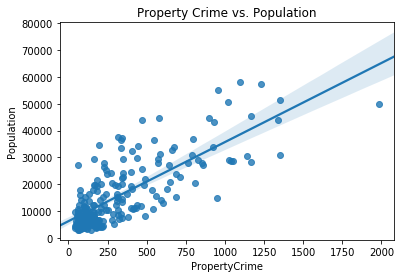

In [806]:
#Now test if Population is linear

sns.regplot(x='PropertyCrime', y='Population', data=nyc_crime)
plt.title('Property Crime vs. Population')
plt.show()

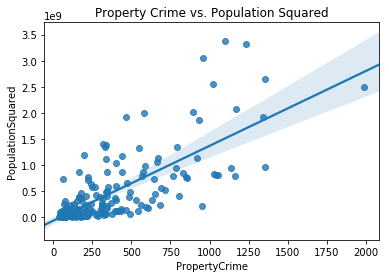

In [807]:
#Test if Population Squared is linear

sns.regplot(x='PropertyCrime', y='PopulationSquared', data=nyc_crime)
plt.title('Property Crime vs. Population Squared')
plt.show()

**Assumption Two:** Multivariate Normality

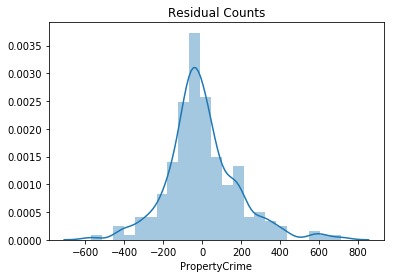

In [808]:
# Extract predicted values.
predicted = regression.predict(X).ravel()
actual = nyc_crime['PropertyCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

sns.distplot(residual)
plt.title('Residual Counts')
plt.show()

**Assumption Three:** Homoscedasticity

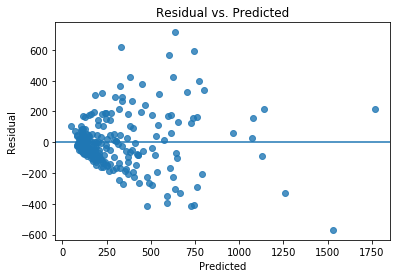

In [809]:
#Plotting residual vs. predicted

sns.regplot(x=predicted, y=residual, fit_reg=False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [810]:
#Let's try to fix the heteroscedasticity seen above. First, we will take the log of Property Crime

nyc_crime['PropertyCrime'] = np.log(nyc_crime['PropertyCrime'])

# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime['PropertyCrime']
X = nyc_crime[['Population', 'PopulationSquared', 'Murder', 'Robbery']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))

# Extract predicted values.
predicted = regression.predict(X).ravel()
actual = nyc_crime['PropertyCrime']

# Calculate the error, also called the residual.
residual = actual - predicted


Coefficients: 
 [ 9.05120508e-05 -9.22900865e-10 -9.79135131e-02  1.11845263e-02]

Intercept: 
 4.25028787596924

R-squared:
0.5899518485980184


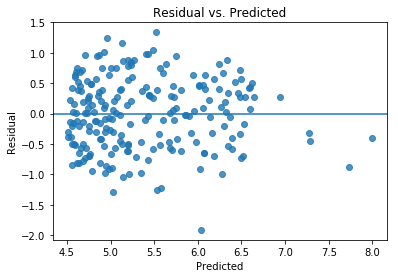

In [811]:
#Test for Homoscedasticity again

#Plotting residual vs. predicted

sns.regplot(x=predicted, y=residual, fit_reg=False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

**Assumption Four:** Low Multicollinearity

In [812]:
#Correlation matrix

correlation_matrix = X.corr()
display(correlation_matrix)

,Population,PopulationSquared,Murder,Robbery
Population,1.000,0.953,0.380,0.518
PopulationSquared,0.953,1.000,0.410,0.554
Murder,0.380,0.410,1.000,0.782
Robbery,0.518,0.554,0.782,1.000


### Try Evaluating parameters using statsmodels

In [813]:
# Write out the model formula.
# Your dependent variable on the left, independent variables on the right
# Use a ~ to represent an '=' from the functional form

linear_formula = 'PropertyCrime ~ Population+PopulationSquared+Murder+Robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=nyc_crime).fit()

In [814]:
#Get R^2
lm.rsquared

0.5899518485980184

In [815]:
#Get coefficients
lm.params

Intercept            4.250
Population           0.000
PopulationSquared   -0.000
Murder              -0.098
Robbery              0.011
dtype: float64

In [816]:
#Get p-values
lm.pvalues

Intercept           0.000
Population          0.000
PopulationSquared   0.000
Murder              0.131
Robbery             0.001
dtype: float64

In [817]:
#Get confidence intervals
lm.conf_int()

,0,1
Intercept,4.054,4.447
Population,0.000,0.000
PopulationSquared,-0.000,-0.000
Murder,-0.225,0.030
Robbery,0.005,0.017


### Let's try a revised model with the original Murdery and Robbery columns

**First clean the data**

In [818]:
nyc_crime_original = nyc_crime_original.dropna(subset=['Population', 'Murder', 'Robbery', 'PropertyCrime'])

In [819]:
#To create population squared feature, first remove commas from amounts
nyc_crime_original['Population'] = nyc_crime_original['Population'].str.replace(',', '')

In [820]:
#Next, convert column from string to int

nyc_crime_original['Population'] = nyc_crime_original['Population'].astype(int)

In [821]:
#Now we can create our new feature!

nyc_crime_original['PopulationSquared'] = nyc_crime_original['Population']**2

In [822]:
#To convert 'Murder' column, first need to convert from string to int

nyc_crime_original['Murder'] = nyc_crime_original['Murder'].astype(int)

In [823]:
#To create converted 'Robbery' column, need to remove commas first

nyc_crime_original['Robbery'] = nyc_crime_original['Robbery'].str.replace(',', '')

In [824]:
#Similarly to population and murder, to convert 'Robbery' column, first need to convert from string to int

nyc_crime_original['Robbery'] = nyc_crime_original['Robbery'].astype(int)

In [825]:
#Finally, remove commas in property crime

nyc_crime_original['PropertyCrime'] = nyc_crime_original['PropertyCrime'].str.replace(',', '')

In [826]:
#Change property crime from string to int
nyc_crime_original['PropertyCrime'] = nyc_crime_original['PropertyCrime'].astype(int)

In [827]:
#Remove commas from Burglary
nyc_crime_original['Burglary'] = nyc_crime_original['Burglary'].str.replace(',', '')

In [828]:
#Convert burglary to int
nyc_crime_original['Burglary'] = nyc_crime_original['Burglary'].astype(int)

In [829]:
#Remove commmas from LarcenyTheft
nyc_crime_original['LarcenyTheft'] = nyc_crime_original['LarcenyTheft'].str.replace(',', '')

In [830]:
#Convert LarcenyTheft to int
nyc_crime_original['LarcenyTheft'] = nyc_crime_original['LarcenyTheft'].astype(int)

**Now look for outliers/skewness**

In [831]:
print(nyc_crime_original['PropertyCrime'].describe())
print(nyc_crime_original['Population'].describe())
print(nyc_crime_original['PopulationSquared'].describe())
print(nyc_crime_original['Murder'].describe())
print(nyc_crime_original['Robbery'].describe())
print(nyc_crime_original['Burglary'].describe())
print(nyc_crime_original['LarcenyTheft'].describe())

count      348.000
mean       792.606
std       7659.725
min          0.000
25%         40.500
50%        112.500
75%        341.000
max     141971.000
Name: PropertyCrime, dtype: float64
count       348.000
mean      40037.632
std      450037.368
min         526.000
25%        3003.000
50%        7233.500
75%       18427.500
max     8396126.000
Name: Population, dtype: float64
count              348.000
mean      203554650960.236
std      3778875542708.130
min             276676.000
25%            9018117.000
50%           52325684.500
75%          339753567.000
max     70494931807876.000
Name: PopulationSquared, dtype: float64
count   348.000
mean      1.566
std      18.304
min       0.000
25%       0.000
50%       0.000
75%       0.000
max     335.000
Name: Murder, dtype: float64
count     348.000
mean       72.902
std      1031.033
min         0.000
25%         0.000
50%         1.000
75%         5.000
max     19170.000
Name: Robbery, dtype: float64
count     348.000
mean      119.

**Transform independent variables one by one**

First, PropertyCrime

In [832]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['PropertyCrime'] > 40.5]

In [677]:
nyc_crime_original['PropertyCrime'].quantile(0.95)

1990.0

In [678]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['PropertyCrime'] < 1990]

Now Population

In [679]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['Population'] > 3003]

In [680]:
nyc_crime_original['Population'].quantile(0.95)

44856.69999999998

In [681]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['Population'] < 78266]

Next Population Squared

In [682]:
nyc_crime_original['PopulationSquared'] = nyc_crime_original['Population']**2

Next Murder

In [834]:
nyc_crime_original['Murder'].quantile(0.95)

3.0

In [835]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['Murder'] <= 3]

Next Robbery

In [836]:
nyc_crime_original['Robbery'].quantile(0.95)

31.0

In [837]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['Robbery'] <= 31]

Next Burglary

In [840]:
nyc_crime_original['Burglary'].quantile(0.95)

132.39999999999998

In [841]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['Burglary'] < 132]

Finally LarcenyTheft

In [842]:
nyc_crime_original['LarcenyTheft'].quantile(0.95)

558.5

In [843]:
nyc_crime_original = nyc_crime_original[nyc_crime_original['LarcenyTheft'] < 558]

In [844]:
# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime_original['PropertyCrime']
X = nyc_crime_original[['Population', 'PopulationSquared', 'Murder', 'Robbery']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 1.02951201e-02 -7.85592832e-08  2.06168133e+01  1.39650216e+01]

Intercept: 
 54.33086032178966

R-squared:
0.5635995902263345


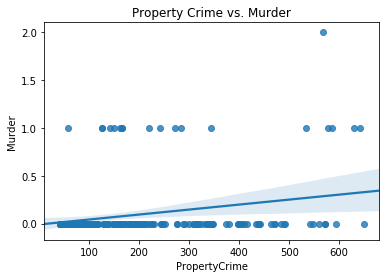

In [845]:
sns.regplot(x='PropertyCrime', y='Murder', data=nyc_crime_original)
plt.title('Property Crime vs. Murder')
plt.show()

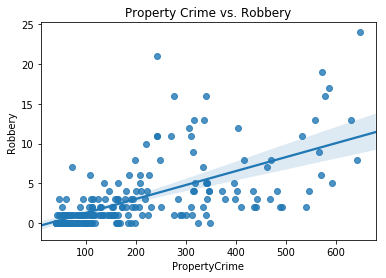

In [846]:
sns.regplot(x='PropertyCrime', y='Robbery', data=nyc_crime_original)
plt.title('Property Crime vs. Robbery')
plt.show()

**Remove Murder and run the model again**

In [847]:
# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime_original['PropertyCrime']
X = nyc_crime_original[['Population', 'PopulationSquared', 'Robbery']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 1.01248081e-02 -7.22025802e-08  1.42788381e+01]

Intercept: 
 55.75527505740362

R-squared:
0.5622595897801561


In [848]:
#Let's evaluate using statsmodels to see if we can build a final version of the model that best explains variance

linear_formula = 'PropertyCrime ~ Population+PopulationSquared+Robbery'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=nyc_crime_original).fit()

In [849]:
lm.pvalues

Intercept           0.000
Population          0.000
PopulationSquared   0.003
Robbery             0.000
dtype: float64

In [850]:
lm.params

Intercept           55.755
Population           0.010
PopulationSquared   -0.000
Robbery             14.279
dtype: float64

**Takeaway:** By adding in the real values for Murder and Robbery, we did not achieve a higher accuracy with our model. In fact, it looks like these features aren't strong at all, aside from PopulationSquared.

### Finally, Let's add Burglary to the model and see what impact that might have.

In [851]:
# Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime_original['PropertyCrime']
X = nyc_crime_original[['Population', 'PopulationSquared', 'Robbery', 'Burglary']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 6.88314629e-03 -5.22079450e-08  1.34502358e+00  3.82689223e+00]

Intercept: 
 11.946951303162592

R-squared:
0.7448940420026822


**Now, this looks a bit more promising. Let's go through our assumptions**

**Assumption One:** Linear Relationship with all variables

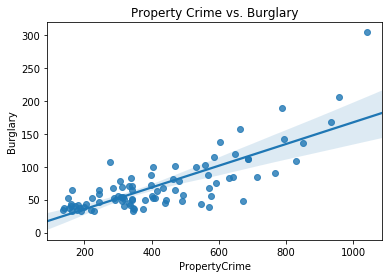

In [769]:
#Let's look at Burglary since we've looked at the others already

sns.regplot(x='PropertyCrime', y='Burglary', data=nyc_crime_original)
plt.title('Property Crime vs. Burglary')
plt.show()

**Assumption Two:** Multivariate Normality

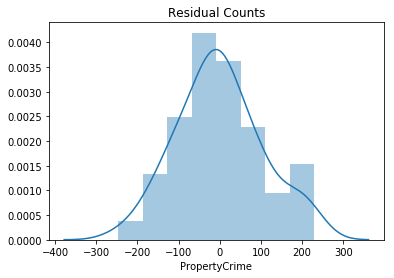

In [770]:
# Extract predicted values.
predicted = regression.predict(X).ravel()
actual = nyc_crime_original['PropertyCrime']

# Calculate the error, also called the residual.
residual = actual - predicted

sns.distplot(residual)
plt.title('Residual Counts')
plt.show()

**Assumption Three:** Homoscedasticity

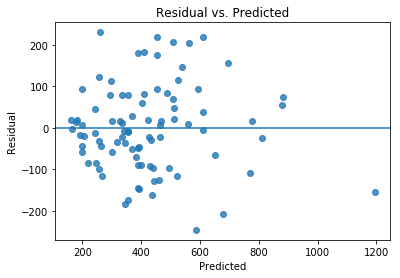

In [771]:
#Plotting residual vs. predicted

sns.regplot(x=predicted, y=residual, fit_reg=False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [854]:
#Let's try to fix this by taking a log of property crime.

nyc_crime_original['PropertyCrime'] = np.log(nyc_crime_original['PropertyCrime'])

In [855]:
#Run the model again

#Instantiate and fit our model.
regression = linear_model.LinearRegression()
Y = nyc_crime_original['PropertyCrime']
X = nyc_crime_original[['Population', 'PopulationSquared', 'Robbery', 'Burglary']]
regression.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regression.coef_)
print('\nIntercept: \n', regression.intercept_)
print('\nR-squared:')
print(regression.score(X, Y))


Coefficients: 
 [ 6.07094624e-06 -6.64680590e-11 -4.53925790e-04  2.35875474e-03]

Intercept: 
 0.3393848791360477

R-squared:
0.6719928677707696


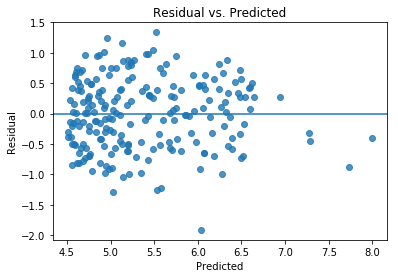

In [856]:
#Plot Residual vs. Predicted again

sns.regplot(x=predicted, y=residual, fit_reg=False)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Now this looks a little better than before.

**Assumption Four:** Low Multicollinearity

In [857]:
#Correlation matrix

correlation_matrix = X.corr()
display(correlation_matrix)

,Population,PopulationSquared,Robbery,Burglary
Population,1.000,0.869,0.492,0.523
PopulationSquared,0.869,1.000,0.337,0.372
Robbery,0.492,0.337,1.000,0.700
Burglary,0.523,0.372,0.700,1.000
